In [2]:
# notebooks/explain_model.ipynb

# Interpret the predictions of the trained XGBoost model using SHAP.
# Helps understand why the model flags certain transactions as fraudulent.

import os
import pandas as pd
import xgboost as xgb
import shap
from sklearn.model_selection import train_test_split

print("Loading data and model for explainability analysis...")

# --- 0. Config ===================================================================
RANDOM_STATE = 42
TEST_SIZE = 0.30
SAMPLE_SIZE = 1000  # upper bound; actual sample size will be min(SAMPLE_SIZE, len(X_test))

DATA_PATH = "../data/PS_20174392719_1491204439457_log.csv"
MODEL_PATH = "../models/fraud_detection_model.xgb"

# --- 1. Load Data and Model ======================================================
if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(f"Data file not found at: {DATA_PATH}")
if not os.path.exists(MODEL_PATH):
    raise FileNotFoundError(f"Model file not found at: {MODEL_PATH}")

df = pd.read_csv(DATA_PATH)

model = xgb.XGBClassifier()
model.load_model(MODEL_PATH)

print("Data and model loaded successfully.")


Loading data and model for explainability analysis...
Data and model loaded successfully.


In [3]:
# --- 2. Recreate the Test Set ====================================================
df_filtered = df[(df["type"] == "TRANSFER") | (df["type"] == "CASH_OUT")].copy()

# Feature engineering (identical to training)
df_filtered["errorBalanceOrig"] = (df_filtered["newbalanceOrig"] + df_filtered["amount"]) - df_filtered["oldbalanceOrg"]
df_filtered["errorBalanceDest"] = (df_filtered["oldbalanceDest"] + df_filtered["amount"]) - df_filtered["newbalanceDest"]
df_filtered["isBlackHoleTransaction"] = (
    (df_filtered["oldbalanceDest"] == df_filtered["newbalanceDest"]) & (df_filtered["amount"] > 0)
).astype(int)

df_filtered = pd.get_dummies(df_filtered, columns=["type"], prefix="type", drop_first=True)

y = df_filtered["isFraud"]
X = df_filtered.drop(["isFraud", "nameOrig", "nameDest", "isFlaggedFraud"], axis=1)

_, X_test, _, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
)


In [4]:
# --- 3. Initialize SHAP ==========================================================
actual_sample_size = min(SAMPLE_SIZE, len(X_test))
if actual_sample_size == 0:
    raise ValueError("X_test is empty after filtering. Cannot run explainability.")

X_test_sample = X_test.sample(n=actual_sample_size, random_state=RANDOM_STATE)
y_test_sample = y_test.loc[X_test_sample.index]

explainer = shap.TreeExplainer(model)
shap_values_sample = explainer.shap_values(X_test_sample)

# expected_value can be scalar (binary) or array-like; normalize to scalar for per-row plots
expected_value = explainer.expected_value
if isinstance(expected_value, (list, tuple, pd.Series)) and len(getattr(expected_value, "__len__", [])) > 1:
    # If model outputs multiple expected values (e.g., for multiclass), take the positive class (last) by convention
    expected_value_scalar = expected_value[-1]
else:
    expected_value_scalar = expected_value

print(f"SHAP values calculated for {actual_sample_size} samples.")


SHAP values calculated for 1000 samples.



Generating global feature importance plot (bar)...


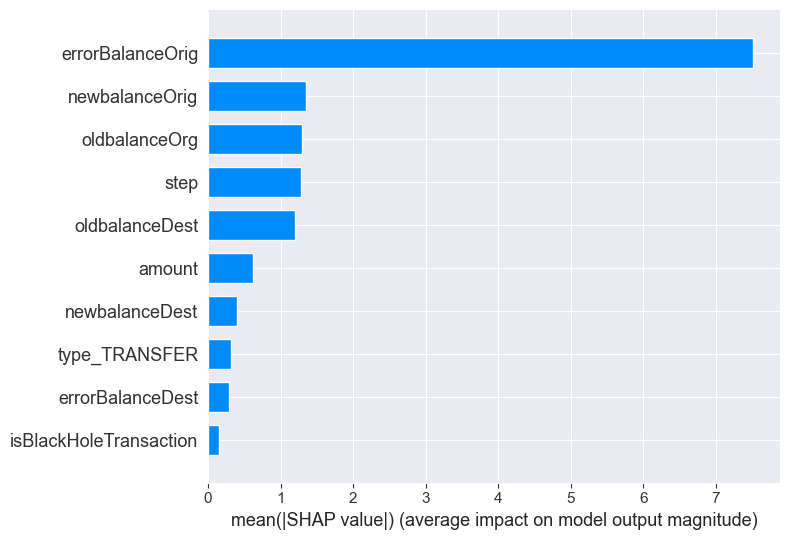


Generating global feature importance plot (beeswarm)...


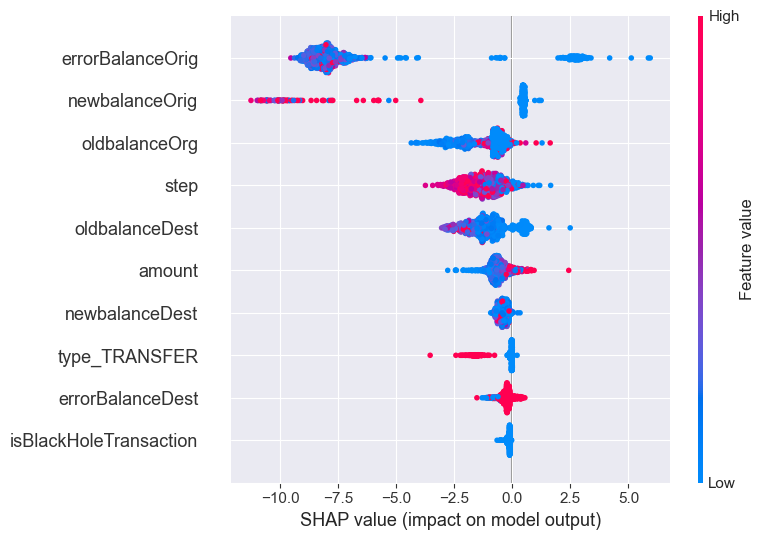

In [5]:
# --- 4. Global Feature Importance Plots ==========================================
print("\nGenerating global feature importance plot (bar)...")
shap.summary_plot(shap_values_sample, X_test_sample, plot_type="bar")

print("\nGenerating global feature importance plot (beeswarm)...")
shap.summary_plot(shap_values_sample, X_test_sample)


<llm-snippet-file>/Users/nangs/Documents/fraud-detection-main/notebooks/explain_model.ipynb</llm-snippet-file>


### SHAP Summary

#### Global feature importance (bar plot)
- Top drivers: `errorBalanceOrig`, `oldbalanceOrg`, `type_TRANSFER`, and `newbalanceDest`.
- Interpretation: The model relies heavily on account balance movements and states—expected for this fraud-detection task.

---

#### Beeswarm plot
- Shows both the magnitude and direction of each feature’s impact. Each dot represents one prediction from the sample set.

- **`errorBalanceOrig`** — most powerful feature
  - High values (red dots) have high positive SHAP values: when there’s a large discrepancy between expected and actual originating balance after a transaction, the model strongly suspects fraud. Classic for account takeover or manipulated transactions.
  - Low values (blue dots) have SHAP values around zero: a correct balance calculation has little impact on the fraud score.

- **`oldbalanceOrg`**
  - Low values (blue dots, especially at 0) have high positive SHAP values: transactions that drain an account completely (starting balance equals transaction amount) are highly suspicious. A low or zero `oldbalanceOrg` is a major red flag.

- **`type_TRANSFER`**
  - Being a transfer (`type_TRANSFER` = 1, red dots) has a universally positive SHAP value: the model has learned that `TRANSFER` transactions are inherently riskier than `CASH_OUT` in this dataset.



Explaining a fraudulent transaction (force plot)...


Generating waterfall plot for the same fraudulent transaction...


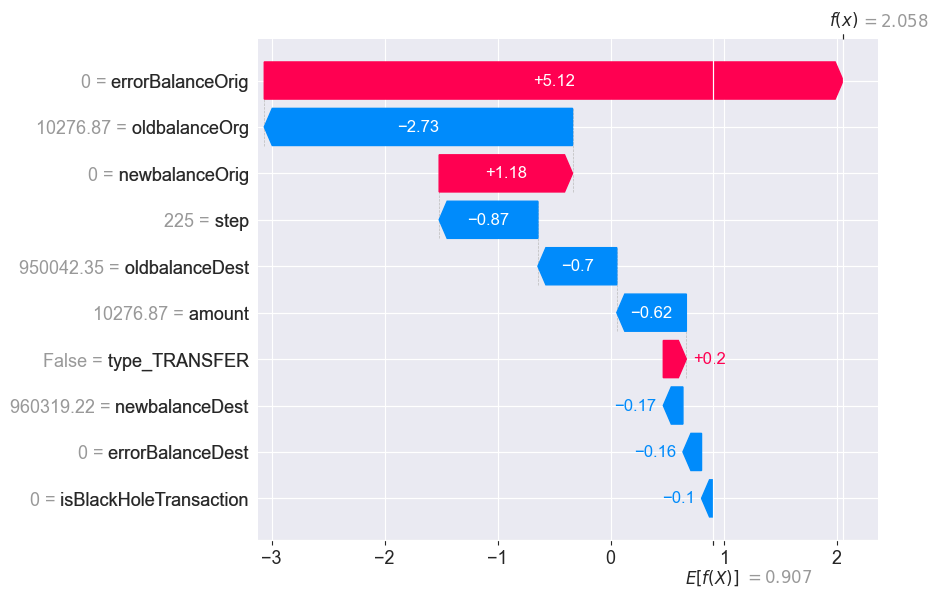


Explaining a legitimate transaction (waterfall plot)...


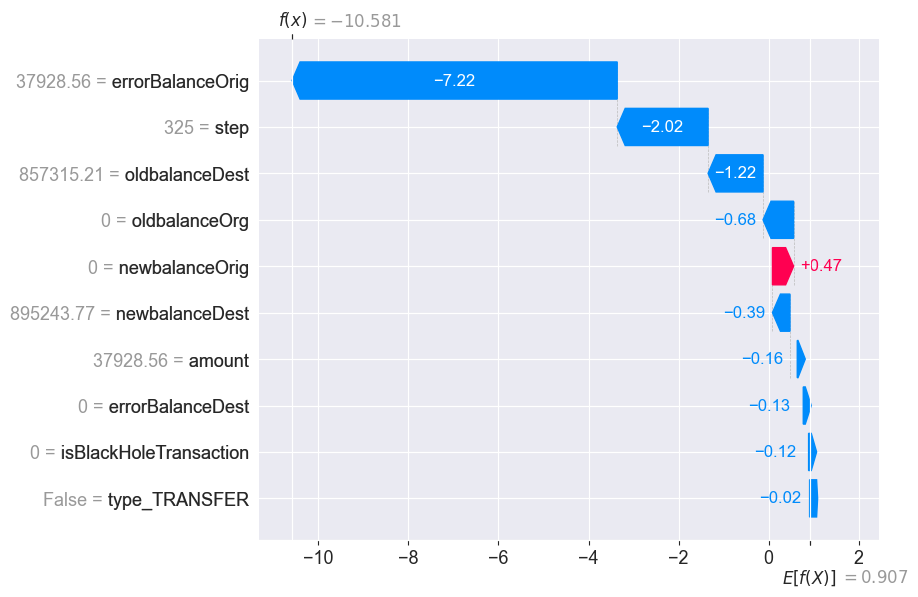

In [12]:
# --- 5. Individual Prediction Explanation Plots ==================================
fraud_in_sample = y_test_sample[y_test_sample == 1].index
legit_in_sample = y_test_sample[y_test_sample == 0].index

def _index_in_sample(ix):
    # Convert a dataframe index value to positional index for SHAP arrays
    return X_test_sample.index.get_loc(ix)

# Force plot (fraud) --------------------------------------------------------------
if len(fraud_in_sample) > 0:
    fraud_idx = fraud_in_sample[0]
    fraud_iloc = _index_in_sample(fraud_idx)
    print("\nExplaining a fraudulent transaction (force plot)...")
    try:
        shap.initjs()
        shap.force_plot(
            expected_value_scalar,
            shap_values_sample[fraud_iloc, :],
            X_test_sample.iloc[fraud_iloc, :]
        )
    except Exception as e:
        print(f"Skipped force plot due to: {e}. If running outside a notebook, consider using shap.plots.waterfall.")

    print("Generating waterfall plot for the same fraudulent transaction...")
    try:
        shap.waterfall_plot(shap.Explanation(
            values=shap_values_sample[fraud_iloc, :],
            base_values=expected_value_scalar,
            data=X_test_sample.iloc[fraud_iloc, :],
            feature_names=X_test_sample.columns.tolist()
        ))
    except Exception as e:
        print(f"Skipped waterfall plot due to: {e}")
else:
    print("\nNo fraudulent examples present in the sampled set; skipping individual fraud plots.")

# Force/Waterfall plot (legitimate) ----------------------------------------------
if len(legit_in_sample) > 0:
    legit_idx = legit_in_sample[0]
    legit_iloc = _index_in_sample(legit_idx)
    print("\nExplaining a legitimate transaction (waterfall plot)...")
    try:
        shap.waterfall_plot(shap.Explanation(
            values=shap_values_sample[legit_iloc, :],
            base_values=expected_value_scalar,
            data=X_test_sample.iloc[legit_iloc, :],
            feature_names=X_test_sample.columns.tolist()
        ))
    except Exception as e:
        print(f"Skipped legitimate waterfall plot due to: {e}")
else:
    print("No legitimate examples present in the sampled set; skipping individual legit plots.")


### Individual Transaction Explanations

These plots support root-cause analysis by showing why a single transaction was flagged. This mirrors what a risk analyst would review.

#### Fraudulent transaction (waterfall)
- Base value: Average model score for the sample; represents the prior before feature contributions.
- Positive drivers (red) — push the score toward fraud:
  - errorBalanceOrig: A large discrepancy in the originating balance is the strongest signal.
  - type_TRANSFER = 1: Transfers are learned as riskier in this dataset.
  - oldbalanceOrg: In combination with amount, certain patterns increase risk.
- Negative drivers (blue) — push the score toward legitimacy:
  - amount: Smaller amounts may slightly decrease risk.
- Outcome: The net contribution pushes the score above the decision threshold, classifying the case as fraud. Key insight: the balance error dominates.

#### Legitimate transaction (waterfall)
- Negative drivers (blue) — push the score toward legitimacy:
  - errorBalanceOrig ≈ 0: A correct balance calculation is the strongest indicator of legitimacy.
  - oldbalanceOrg > 0: A non-zero starting balance supports a legitimate pattern.
- Outcome: The net contribution pulls the score below the decision threshold, correctly classifying the case as legitimate.



Generating dependence plot for 'oldbalanceOrg' with interaction='amount'...


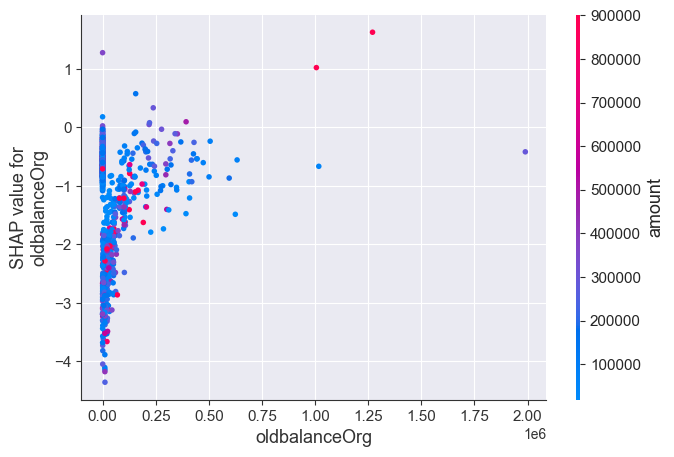

Generating dependence plot for 'amount' with interaction='isBlackHoleTransaction'...


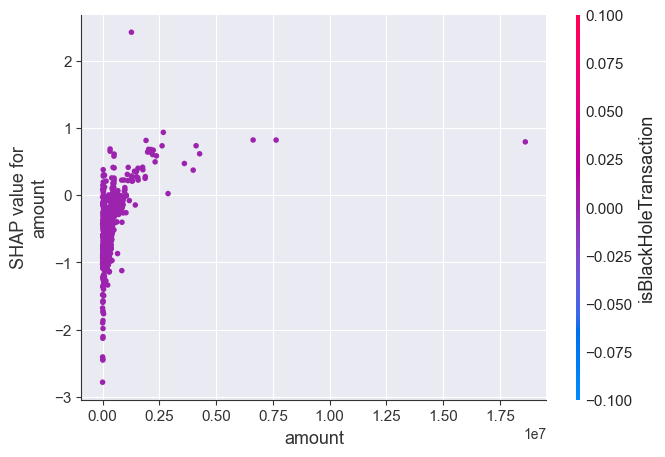


--- Explainability Analysis Complete ---


In [7]:
# --- 6. Feature Dependence Plots =================================================
if "oldbalanceOrg" in X_test_sample.columns and "amount" in X_test_sample.columns:
    print("\nGenerating dependence plot for 'oldbalanceOrg' with interaction='amount'...")
    shap.dependence_plot("oldbalanceOrg", shap_values_sample, X_test_sample, interaction_index="amount")
else:
    print("\nSkipping 'oldbalanceOrg' dependence plot (required columns not found).")

if "amount" in X_test_sample.columns and "isBlackHoleTransaction" in X_test_sample.columns:
    print("Generating dependence plot for 'amount' with interaction='isBlackHoleTransaction'...")
    shap.dependence_plot("amount", shap_values_sample, X_test_sample, interaction_index="isBlackHoleTransaction")
else:
    print("Skipping 'amount' dependence plot (required columns not found).")

print("\n--- Explainability Analysis Complete ---")


### Dependence Plot: `oldbalanceOrg` (interaction: `amount`)

- Main effect (`oldbalanceOrg`):
  - SHAP values are strongly positive when `oldbalanceOrg` is near zero, forming a dense vertical band at the far left.
  - As `oldbalanceOrg` increases, SHAP values trend negative, indicating legitimacy.

- Interaction (`amount`):
  - High-amount transactions (red/purple points) concentrate in that near-zero `oldbalanceOrg` band.
  - The combination of low `oldbalanceOrg` and high `amount` yields the highest fraud scores, reflecting an account-draining pattern.

---

### Takeaway
The model flags transactions from near-empty accounts, and it becomes especially confident when the transfer amount is large. The engineered `errorBalanceOrig` feature reinforces this by capturing balance inconsistencies typical of fraudulent activity.
